# An Attempt to Integrate Everything

C. Chen 20251212

## Felix's code for downloading image data from observatories

This code is heavily based on the code provided to us by Dr. Harding, Alex Toohey, Tommy Duong, and Sabrina Nazarzai on a research project using the pyaurorax package. The part of the code that downloads the data is essentially the same, with a few changes to variables and flow. The code for the multiple day downloading was also based on their code with changes to the logic and the specified parameters to allow for more control over data downloading. The saving of the frames as pdfs is original code.

In [1]:
import h5py
import numpy as np
from datetime import datetime, timedelta
import pyaurorax as auro
import os
import shutil
import matplotlib.pyplot as plt

/Users/ctychen/Desktop/Physics/188/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_data(start_time,end_time,site_id,cleanup=True):
    aurorax = auro.PyAuroraX() #creating class instance
    dataset_name = "TREX_RGB_RAW_NOMINAL" #name of dataset that will be used for extracting data
    download = aurorax.data.ucalgary.download(dataset_name=dataset_name,start=start_time,end=end_time,site_uid=site_id) #downloads the data, takes a while

    frames = [] #don't know the number of elements and frames is in a shape that is pre-assigned, making list appending easier

    for filename in download.filenames: #loops over each image downloaded
        with h5py.File(filename,'r') as f: #uses h5py file for efficient data storage and extraction
            images = f['data/images'][:].transpose(3,0,1,2) #transposes the matrix so it is in shape [N,H,W,C] where N is frame number, H is height, 
            #W is width of image, and C is the RGB color chanel (0-2)
            timestamp_data = f['data/timestamp'][:] #extracts the time the image was taken
            times = [datetime.fromisoformat(t.decode('utf-8').replace(' UTC','')).replace(tzinfo=None,microsecond=0) for t in timestamp_data]
            #the above code takes a byte object from the h5py file decodes it into a string, replaces the timezone, makes it into a datetime object,
            #then ensures that object is timezone-naive and drops the fractional seconds

            #sampling frames so that we don't have too much data as most of the images will be the same. 
            last_minute = None
            for i,t in enumerate(times): #loops over the times
                if (t.hour,t.minute) != last_minute: #filters out data from the same minute, captures 1 frame per minute
                    frames.append(images[i])
                    last_minute = (t.hour,t.minute)

    #to delete the repository after samples frames from the original 
    if cleanup == True and download.filenames:
    # Find the pyaurorax_data root directory
        first_file = str(download.filenames[0])  # Convert to string
        # Navigate up to find pyaurorax_data
        path_parts = first_file.split(os.sep)
        if 'pyaurorax_data' in path_parts:
            idx = path_parts.index('pyaurorax_data')
            root_dir = os.sep.join(path_parts[:idx+1])
            try:
                shutil.rmtree(root_dir) #removes directory
                print(f"Removed download directory: {root_dir}")
            except Exception as e:
                print(f"Warning: Could not remove directory {root_dir}: {e}")
    return np.array(frames)

In [3]:
"""start = datetime(2024, 1, 15, 0, 0, 0)
end = datetime(2024, 1, 15, 23, 59, 59)
site_uid = "gill" 
frames, timestamps, locations = download_data(start, end, site_uid)

print(frames.shape)"""
#testing stuff

'start = datetime(2024, 1, 15, 0, 0, 0)\nend = datetime(2024, 1, 15, 23, 59, 59)\nsite_uid = "gill" \nframes, timestamps, locations = download_data(start, end, site_uid)\n\nprint(frames.shape)'

In [4]:
def run_download(start_date, end_date, site, start_hour = 0, end_hour=4):
    #actually runs the download for multiple days if necessary, has the time preset to the time when auroras are usually expected.
    #note: start_date, end_date are datetime objects, start_hour, end_hour are ints, site is a string.
    
    all_frames = [] #again, not sure how large the array or list needs to be, so using empty list
    all_sites = []
    
    if type(site) == str:
        site = [site]

    current_date = start_date
    while current_date <= end_date: #loop over days
        day_start = current_date.replace(hour=start_hour, minute=0, second=0) #using a datetime object and leaving the year, month, day unchanged
        day_end = current_date.replace(hour=end_hour, minute=59, second=59)
        
        for loc in site: #loops over multiple sites
            frames = download_data(day_start,day_end,site_id=loc,cleanup=True) #makes the frames
            n = frames.shape[0]
            all_frames.append(frames)
            all_sites.extend([loc]*n)

        current_date += timedelta(days=1) #increment the current date by 1 using timedelta

    return all_frames, np.array(all_sites)

In [5]:
def save_frames(frames, sites,dir_name = "observation_images"):
    #function saves the frames 
    out_dir = dir_name
    os.makedirs(out_dir,exist_ok=True) #makes a new directory, doesn't crash if the directory already exists
    for i in range(frames.shape[0]):
        plt.imsave(os.path.join(out_dir, f"{sites[i]}_frame_{i:07d}.png"),frames[i]) #saves the images as png for classification
    return

In [6]:
#test cell
#note datetime follow this pattern:
#(xxxx, xx, xx, xx, xx, xx)
#(year, month, day, hour, minute, second)
#all arguments are not necessary
# may 10-13 2024 geomagnetic storm as baseline 
start_date = datetime(2024,9,17) #datetime(2024,5,10)
end_date = datetime(2024,9,17) #datetime(2024,5,13)
start_hour = 4 
end_hour= 6
# site = ["fsmi","luck","pina","rabb","yknf","gill","atha"]
site = ["fsmi", "luck", "pina", "rabb", "yknf", "atha"]

all_frames, all_loc = run_download(start_date=start_date,end_date=end_date,site=site, start_hour=start_hour, end_hour=end_hour)

Removed download directory: /Users/ctychen/pyaurorax_data


Removed download directory: /Users/ctychen/pyaurorax_data


Removed download directory: /Users/ctychen/pyaurorax_data


Removed download directory: /Users/ctychen/pyaurorax_data


Removed download directory: /Users/ctychen/pyaurorax_data


Removed download directory: /Users/ctychen/pyaurorax_data


In [7]:
list_of_frames = []
for frames in all_frames:
    list_of_frames.extend(frames)
list_of_frames = np.array(list_of_frames)

save_frames(list_of_frames, all_loc)

In [8]:
test = auro.PyAuroraX()
print(test.data.ucalgary.list_datasets())
obs = test.data.ucalgary.list_observatories('trex_rgb')
for i in range(len(obs)):
    print(obs[i].uid)

[Dataset(name=REGO_CALIBRATION_FLATFIELD_IDLSAV, short_description='REGO All Sky Imagers Flatfield calibration data (IDL save format)', provider='UCalgary', level='L3', doi_details='https://commons.datacite.org/doi.org/10.11575/z7x6-5c42', ...), Dataset(name=REGO_CALIBRATION_RAYLEIGHS_IDLSAV, short_description='REGO All Sky Imagers Rayleighs calibration data (IDL save format)', provider='UCalgary', level='L3', doi_details='https://commons.datacite.org/doi.org/10.11575/z7x6-5c42', ...), Dataset(name=REGO_DAILY_KEOGRAM_JPG, short_description='REGO All Sky Imagers daily keogram summary product (JPG format)', provider='UCalgary', level='L2', doi_details='https://commons.datacite.org/doi.org/10.11575/z7x6-5c42', ...), Dataset(name=REGO_DAILY_KEOGRAM_PGM, short_description='REGO All Sky Imagers daily keogram summary product (PGM format)', provider='UCalgary', level='L2', doi_details='https://commons.datacite.org/doi.org/10.11575/z7x6-5c42', ...), Dataset(name=REGO_DAILY_KEOGRAM_PNG, short_de

## Bringing in Ishaan's code for colors

In [1]:
import numpy as np
from matplotlib import image as mpimg
from scipy import ndimage
from matplotlib import pyplot as plt, image as mpimg
from sklearn.cluster import KMeans
from skimage.color import rgb2hsv, rgb2lab
import zipfile
import os
os.environ["OMP_NUM_THREADS"] = "6"

In [2]:
### The main function
def binary_filtering(img, K=3, luminosity_threshold=40,
        hsv_green=(60, 125),
        hsv_red1=(0, 10),
        hsv_red2=(350, 360),
        hsv_blue=(220, 250),
        max_hue_std=15
    ):
    ## Preprocessing
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32) / 255.0

    h, w, _ = img.shape
    flat = img.reshape(-1, 3)

    ## Cluster
    kmeans = KMeans(n_clusters=K, n_init="auto").fit(flat)
    # remove alpha if present
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[..., :3]
    flat = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=K, n_init="auto").fit(flat)
    labels = kmeans.labels_.reshape(h, w)

    ## Color
    hsv = rgb2hsv(img)
    H = hsv[:, :, 0] * 360

    lab = rgb2lab(img)
    L = lab[:, :, 0]

    ## Cuts
    for k in range(K):
        mask = (labels == k)
        cluster_lum = np.max(L[mask])

        if cluster_lum < luminosity_threshold:
            continue
            
        cluster_hue = np.mean(H[mask])
        cluster_hue_std = np.std(H[mask])

        # Skip clusters with inconsistent hue
        if cluster_hue_std > max_hue_std:
            continue

        # Check if the cluster hue corresponds to aurora colors
        green = hsv_green[0] <= cluster_hue <= hsv_green[1]
        red = (hsv_red1[0] <= cluster_hue <= hsv_red1[1]) or (hsv_red2[0] <= cluster_hue <= hsv_red2[1])
        blue = hsv_blue[0] <= cluster_hue <= hsv_blue[1]

        if green or red or blue:
            return True
    ## Additional check: hue at max luminosity pixel
    Lmax = L.max()
    luminous_mask = L >= 0.9 * Lmax

    labels, num_labels = ndimage.label(luminous_mask)
    if num_labels == 0:
        return False
        
    sizes = ndimage.sum(luminous_mask, labels, index=range(1, num_labels + 1))
    ## Find the largest luminous region
    largest_label = np.argmax(sizes) + 1
    largest_size = sizes[largest_label - 1]

    ## Require region size > 200 pixels
    if largest_size <= 200:
        return False
    region_hues = H[labels == largest_label]
    region_hue = np.median(region_hues)

    green = hsv_green[0] <= region_hue <= hsv_green[1]
    red = (hsv_red1[0] <= region_hue <= hsv_red1[1]) or (hsv_red2[0] <= region_hue <= hsv_red2[1])
    blue = hsv_blue[0] <= region_hue <= hsv_blue[1]

    if green or red or blue:
        return True
    ## If no prior condition is met:
    return False

In [29]:
test_folder = "obs_test"
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
N = len(image_files)

filtered = [False]*N

for i,image in enumerate(image_files):
    img_path = os.path.join(test_folder, image)
    img = mpimg.imread(img_path)
    truth = binary_filtering(img)
    filtered[i]=truth
print(np.sum(filtered),N)

100 174


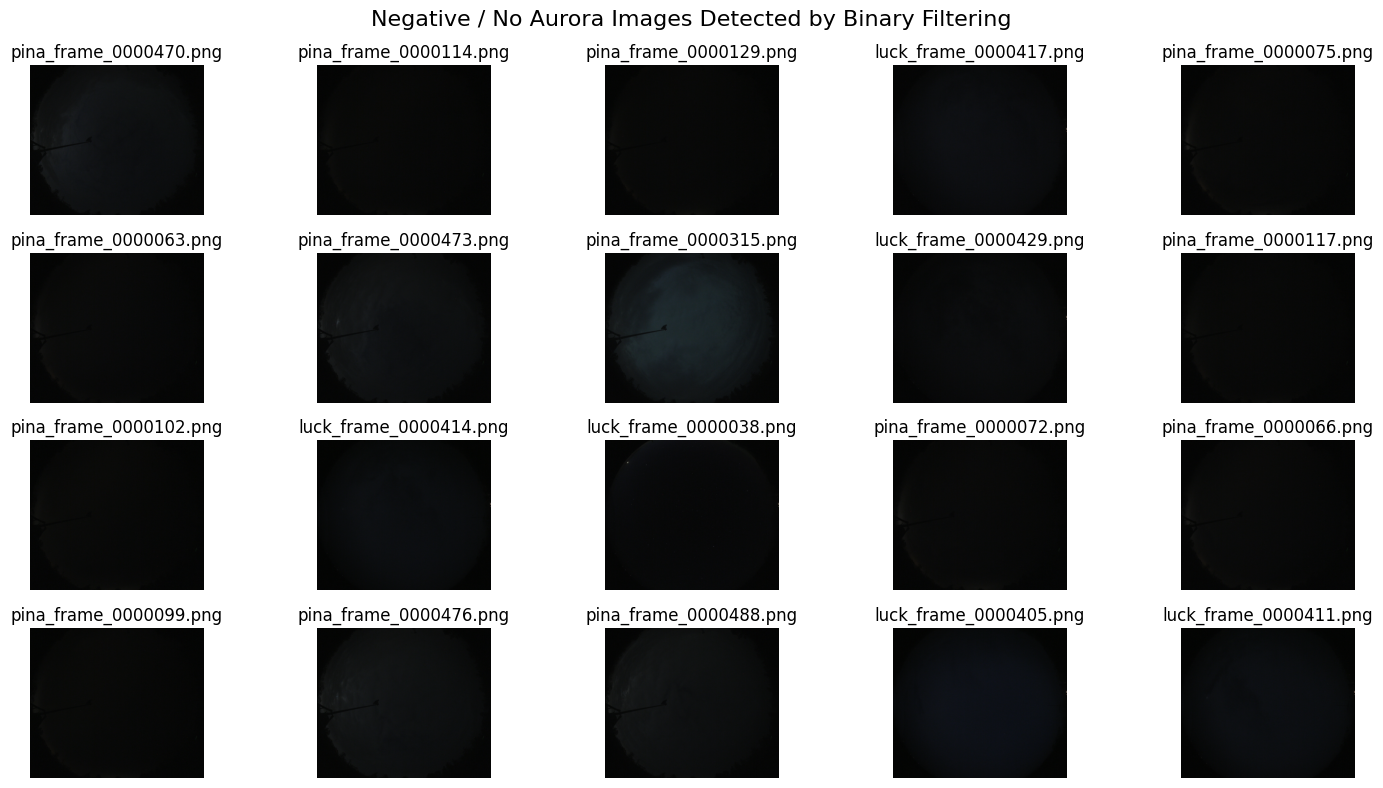

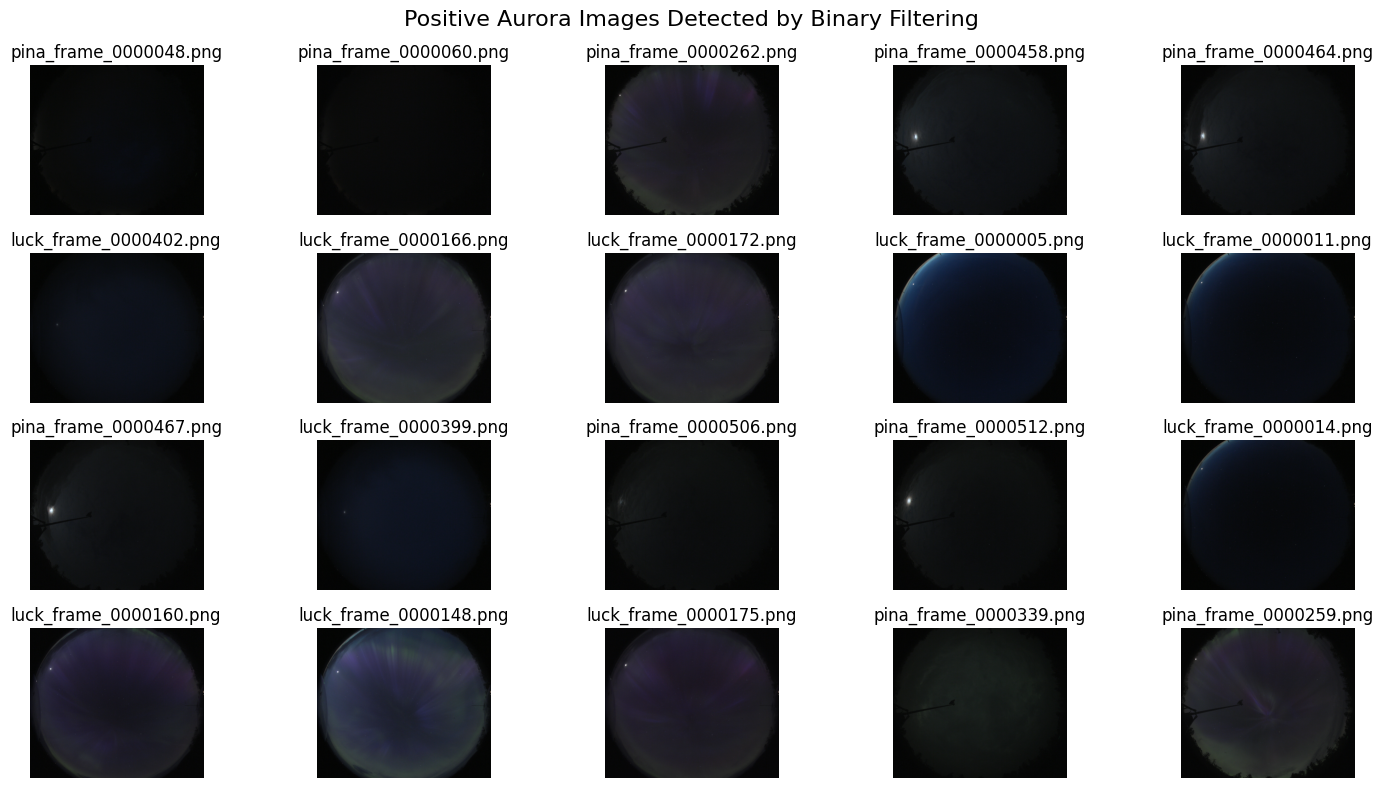

In [40]:
false_indices = [i for i, val in enumerate(filtered) if not val]
idx = false_indices[:20]
plt.figure(figsize=(15, 8))

for idx, image_idx in enumerate(idx):
    img_path = os.path.join(test_folder, image_files[image_idx])
    img = mpimg.imread(img_path)
    
    plt.subplot(4, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_files[image_idx])

plt.suptitle("Negative / No Aurora Images Detected by Binary Filtering", fontsize=16)
plt.tight_layout()
plt.show()

true_indices = [i for i, val in enumerate(filtered) if val]
idx = true_indices[:20]
plt.figure(figsize=(15, 8))
for idx, image_idx in enumerate(idx):
    img_path = os.path.join(test_folder, image_files[image_idx])
    img = mpimg.imread(img_path)
    
    plt.subplot(4, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_files[image_idx])
plt.suptitle("Positive Aurora Images Detected by Binary Filtering", fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
import os
import warnings
import numpy as np
from matplotlib import image as mpimg
from skimage.color import rgb2hsv
from sklearn.cluster import MiniBatchKMeans

### Note this is not really needed, it was just a sanity check to see
### what color an aurora is lol
### Also note that this gets mean dominant hue, so the actual range is larger

# Suppress the MKL KMeans warning on Windows
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

def get_dominant_hue(folder_path, num_clusters=3, min_saturation=0.2, min_value=0.1, max_images=3000):
    """
    Computes robust hue ranges for green, red, and blue auroras from a folder of images.
    
    Parameters:
    - folder_path: folder containing aurora images
    - num_clusters: number of dominant hues to find per image
    - min_saturation: ignore pixels with S < this
    - min_value: ignore pixels with V < this
    - max_images: only process first N images
    
    Returns:
    - hue_ranges: dict with keys 'green', 'red', 'blue', each a (min,max) tuple
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_files = image_files[:max_images]  # limit to first max_images
    
    all_cluster_hues = []

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)

        # Normalize to 0-1 if needed
        if img.dtype != np.float32 and img.dtype != np.float64:
            img = img.astype(np.float32) / 255.0

        # remove alpha if present
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[..., :3]
        flat = img.reshape(-1, 3)

        # Convert to HSV
        hsv = rgb2hsv(img)
        H = hsv[:, :, 0] * 360  # degrees
        S = hsv[:, :, 1]
        V = hsv[:, :, 2]

        # Mask dark / unsaturated pixels
        mask = (V > min_value) & (S > min_saturation)
        H_masked = H[mask].reshape(-1, 1)
        if H_masked.size == 0:
            continue

        # Cluster hues in 1D using MiniBatchKMeans with large batch_size to avoid MKL warning
        k = min(num_clusters, H_masked.shape[0])
        kmeans = MiniBatchKMeans(n_clusters=k, n_init="auto", batch_size=5000).fit(H_masked)
        cluster_centers = kmeans.cluster_centers_.flatten()

        # Save cluster centers for aggregation
        all_cluster_hues.extend(cluster_centers)

    all_cluster_hues = np.array(all_cluster_hues)

    # Assign clusters to approximate color ranges
    green_hues = all_cluster_hues[(all_cluster_hues >= 80) & (all_cluster_hues <= 140)]
    red_hues = all_cluster_hues[(all_cluster_hues <= 20) | (all_cluster_hues >= 340)]
    blue_hues = all_cluster_hues[(all_cluster_hues >= 200) & (all_cluster_hues <= 260)]

    def compute_range(arr):
        if len(arr) == 0:
            return None
        return (np.min(arr), np.max(arr))

    hue_ranges = {
        "green": compute_range(green_hues),
        "red": compute_range(red_hues),
        "blue": compute_range(blue_hues)
    }

    return hue_ranges

In [35]:
folder = "obs_train" 
hue_ranges = get_dominant_hue(folder)
print("Calibrated hue ranges (degrees):")
print(hue_ranges)

Calibrated hue ranges (degrees):
{'green': (np.float32(84.46026), np.float32(139.93059)), 'red': (np.float32(0.0), np.float32(353.7355)), 'blue': (np.float32(200.172), np.float32(259.93115))}


100.0
Hue at max luminosity pixel (degrees): 0.0


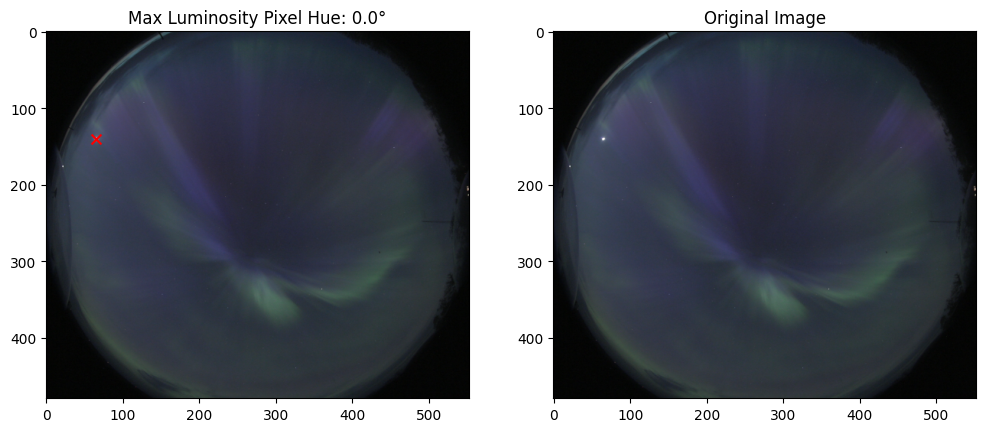

In [13]:
img_path = "obs_train/luck_frame_0000150.png" # aurora with moon
# img_path = "obs_train/pina_frame_0000341.png" # no aurora no moon
img = mpimg.imread(img_path)

# Convert to float 0-1 if needed
if img.dtype != np.float32 and img.dtype != np.float64:
    img = img.astype(np.float32) / 255.0

# remove alpha if present
if img.ndim == 3 and img.shape[2] == 4:
    img = img[..., :3]

# Convert to LAB color space
lab = rgb2lab(img)
L = lab[:, :, 0]  # L channel = lightness/luminosity
print(np.max(L))

max_idx = np.unravel_index(np.argmax(L), L.shape)
hsv = rgb2hsv(img)
H = hsv[:, :, 0] * 360  # degrees

# Hue at the brightest pixel
max_hue = H[max_idx]
print("Hue at max luminosity pixel (degrees):", max_hue)

# Show the image with max luminosity pixel marked - side by side with original
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title(f"Max Luminosity Pixel Hue: {max_hue:.1f}°")
ax[0].scatter([max_idx[1]], [max_idx[0]], color='red', s=50, marker='x')
ax[1].imshow(img)
ax[1].set_title(f"Original Image")
plt.show()